In [96]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('./../../../../')
sys.path.append('./../../../script/')
sys.path.append('./')
sys.path.append('./designer/script/')

from tmm.get_E import get_E_free
from tmm.get_jacobi_arb_adjoint import get_jacobi_E_free_form
from tmm.get_jacobi_adjoint import get_jacobi_adjoint
from tmm.get_spectrum import get_spectrum_free
from film import FreeFormFilm, TwoMaterialFilm
from tmm.autograd_wrapper import *
from tmm.E_to_spectrum import *

import matplotlib.pyplot as plt
import numpy as np



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Manual diff

# autograd r

In [126]:
# autograd

# set exp 
wls = np.linspace(500, 1000, 500)
inc_ang = 60.
np.random.seed(0)
film = FreeFormFilm(np.random.rand(20) * 1 + 1.5, 1000, 2)
d = film.get_d()
n_layers, n_sub, n_inc = film.calculate_n_array(wls), film.calculate_n_sub(wls), film.calculate_n_inc(wls)


# objective: 0.5
def loss_fn(E):
    e = E_to_R(E)
    dif = e - 0.5
    return dif.square().sum()

jacobi_auto = get_jacobi_warpper(loss_fn)
jacobi = np.zeros((wls.shape[0] * 4, d.shape[0], 2, 2))


jacobi = jacobi_auto(    
    jacobi,
    wls,
    d,
    n_layers,
    n_sub,
    n_inc,
    inc_ang,    
)

E_gt = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    E_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)



In [127]:


E = torch.tensor(E_gt, requires_grad=True, device='cuda')
jacobi_y_wrt_E = torch.autograd.grad(loss_fn(E), E)[0].t() # t for correct subsequent reshape

loss_old = loss_fn(torch.tensor(E_gt))
E_new = E_gt.copy()
E_new[0, 0] += 1e-5
loss_new = loss_fn(torch.tensor(E_new))
print((loss_new - loss_old) * 1e5)
print(jacobi_y_wrt_E[0, 0])

raise ValueError('ex: jacobi_E_wrt_M * jacobi_M_wrt_x, need to change autograd_wrapper')
print((ex * jacobi_y_wrt_E.reshape(-1, 1, 1, 1).conj()).sum((0, -1, -2)))

E_gt = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    E_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
E_gt_n = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
d_old = film.get_d().copy()
d = d_old.copy()
d[0] += 1e-5
film.update_d(d)
get_E_free(
    E_gt_n, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
film.update_d(d_old)

print((loss_fn(torch.tensor(E_gt_n)) - loss_fn(torch.tensor(E_gt))) * 1e5)


tensor(-1.1591e-05, dtype=torch.float64)
tensor(-1.1596e-05-0.0039j, device='cuda:0', dtype=torch.complex128)


ValueError: ex: jacobi_E_wrt_M * jacobi_M_wrt_x, need to change autograd_wrapper

In [128]:
jacobian_gt = np.zeros((wls.shape[0] * 2, film.get_d().shape[0]))
get_jacobi_adjoint(
    jacobian_gt, wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
spec_gt = np.zeros((wls.shape[0] * 2))
get_spectrum_free(
    spec_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
grad_gt = 8 * jacobian_gt[:wls.shape[0], :].T * (spec_gt[:wls.shape[0]] - 0.5)

print('gt: analytic')
print(grad_gt.sum(-1))

grad_diff = np.zeros(film.get_layer_number())
for i in range(film.get_layer_number()):
    d_original = film.get_d().copy()
    d = d_original.copy()
    d[i] += 1e-5
    film.update_d(d)
    spec_gt_var = np.zeros((wls.shape[0] * 2))
    get_spectrum_free(
        spec_gt_var, 
        wls, 
        film.get_d(), 
        film.calculate_n_array(wls), 
        film.calculate_n_sub(wls), 
        film.calculate_n_inc(wls), 
        inc_ang, 
    )
    film.update_d(d_original)
    grad_diff[i] = (np.square(spec_gt_var - 0.5).sum() - np.square(spec_gt - 0.5).sum()) / 1e-5
print('gt: diff')
print(grad_diff)

print('autograd')
print(2 * jacobi)

gt: analytic
[ 0.18052409  0.08108158  0.08882581  0.04742077  0.05128622 -0.10153213
 -0.15792294  0.09287371  0.05210349  0.01948709  0.12095558  0.06449845
  0.07955915 -0.15797572  0.07643038  0.08948597  0.0305142   0.09187629
  0.13207279  0.14224309]
gt: diff
[ 0.18052413  0.08108161  0.08882583  0.04742078  0.05128625 -0.1015321
 -0.15792294  0.09287373  0.05210351  0.01948711  0.1209556   0.06449847
  0.07955917 -0.15797566  0.07643042  0.08948602  0.03051424  0.0918763
  0.13207279  0.1422431 ]
autograd
tensor([ 0.1216,  0.0151,  0.1483,  0.1159,  0.0400, -0.1492, -0.1842,  0.1103,
         0.0673,  0.0338,  0.1159,  0.0397,  0.1019, -0.1390,  0.0673,  0.0311,
        -0.0174,  0.1133,  0.1636,  0.1397], device='cuda:0',
       dtype=torch.float64)


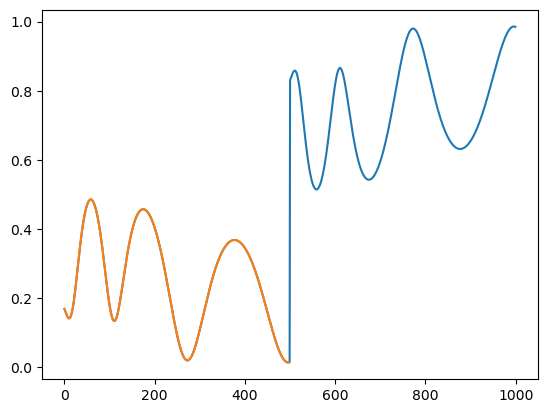

In [199]:
import matplotlib.pyplot as plt
plt.plot(spec_gt)
r = (E[:, 1] / E[:, 0]).abs().square().cpu().detach()
plt.plot(r[:wls.shape[0]] * 0.5 + r[wls.shape[0]:] * 0.5)

# test ellipsometry

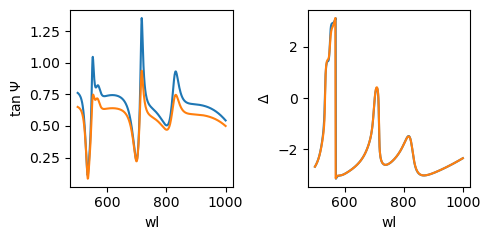

In [122]:
# set exp 
wls = np.linspace(500, 1000, 500)
inc_ang = 45.
np.random.seed(0)
film = TwoMaterialFilm(2.5, 1.5, 2, np.random.random(20) * 100)
d = film.get_d()
n_layers, n_sub, n_inc = film.calculate_n_array(wls), film.calculate_n_sub(wls), film.calculate_n_inc(wls)

tanpsi = np.arctan(film.get_spec(inc_ang, wls).get_tanPsi())
delta = film.get_spec(inc_ang, wls).get_delta()

# target spec
np.random.seed(10)
film_target = TwoMaterialFilm(2.5, 1.5, 2, np.random.random(20) * 1 - 0.5 + film.get_d())
E_target = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    E_target, 
    wls, 
    film_target.get_d(), 
    film_target.calculate_n_array(wls), 
    film_target.calculate_n_sub(wls), 
    film_target.calculate_n_inc(wls), 
    inc_ang, 
)
E_target = torch.tensor(E_target)
target_psi = E_to_Psi(E_target)
target_edelta = E_to_ephase(E_target)

# test spectra
fig, ax = plt.subplots(1, 2)
ax[0].plot(wls, (target_psi), label='pert')
ax[0].plot(wls, np.arctan(tanpsi), label='seed: 0')
ax[1].plot(wls, torch.angle(target_edelta), label='pert')
ax[1].plot(wls, delta, label='seed: 0')
           

for axi in ax:
    axi.set_xlabel('wl')
ax[0].set_ylabel('$\\tan \\Psi$')
ax[1].set_ylabel('$\\Delta$')

fig.set_size_inches(5, 2.5)
fig.tight_layout()

# ax[1].set_ylim(1.4, 3)

In [124]:
# autograd grad: tan2psi

def loss_fn(E):
    e = E_to_R(E) # NOTE: we want psi because tanpsi is not bounded. delta is okay though
    dif = e - target_psi.to(e.device)
    return dif.abs().square().sum()

jacobi_auto = get_jacobi_warpper(loss_fn)
jacobi = np.zeros((wls.shape[0] * 4, film.get_d().shape[0], 2, 2))

jacobi = jacobi_auto(    
    jacobi,
    wls,
    film.get_d(),
    n_layers,
    n_sub,
    n_inc,
    inc_ang,    
)

print(jacobi)

# diff

grad_diff = np.zeros(film.get_layer_number())

spec_gt = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    spec_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
for i in range(film.get_layer_number()):
    d_original = film.get_d().copy()
    d = d_original.copy()
    d[i] += 1e-5
    film.update_d(d)
    spec_gt_var = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
    get_E_free(
        spec_gt_var, 
        wls, 
        film.get_d(), 
        film.calculate_n_array(wls), 
        film.calculate_n_sub(wls), 
        film.calculate_n_inc(wls), 
        inc_ang, 
    )
    film.update_d(d_original)
    grad_diff[i] = (loss_fn(spec_gt_var) - loss_fn(spec_gt)) / 1e-5
print('gt: diff')
print(grad_diff)


tensor([ 0.3398,  0.4455,  1.2663,  0.8459,  1.6738,  0.8956,  1.3300,  0.5423,
         1.0234,  0.8937,  1.1188,  0.3402,  0.0831,  0.2082,  1.4035,  0.2415,
         1.3148,  0.2546, -0.0771, -0.1744], device='cuda:0',
       dtype=torch.float64)
gt: diff
[ 0.3478693   0.4862589   1.29064801  0.92275299  1.70578992  0.96527025
  1.35683649  0.57975443  1.04575291  0.96077914  1.14090717  0.36124532
  0.08762497  0.2163328   1.42720349  0.25117628  1.33977     0.27639489
 -0.07669715 -0.18793774]
